#### sustainabiltiy based on feature stats analysis
- read feat_stats under "/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean"
- positive buoyancy measures, BL+ (area size of BL+, mean amplitude of BL+)

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['mathtext.default'] = 'regular'

In [3]:
# # set fonts configuration - Arial
# matplotlib.rcParams['font.family'] = "Open Sans"
# matplotlib.rcParams['font.sans-serif'] = "Arial"

In [ ]:
# %%time
# stats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase')

# year_list = np.arange(2001,2002)

# BLp_dtypes = []

# for (duration_min, duration_max, duration_type) in zip([5,12,24,36],[12,24,36,72],
#                                            ['SL','ML','LL','UL','UUL']):
#     core_area_list = []
#     mcs_area_list = []
#     BL_TOT_mcs_list = []
#     BL_CAPE_mcs_list = []
#     BL_SUBSAT_mcs_list = []
#     BLp_mean_amp_list = []
#     BLp_area_list = []
#     Tb_min_list = []
#     #corr_coeff_temp_list = []
    
#     for year in year_list:
    
#         BLp_mean_stats = []
#         data = xr.open_dataset(stats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
       
#         mcs_duration = data.mcs_duration
#         cond_1 = mcs_duration >= duration_min
#         cond_2 = mcs_duration < duration_max
#         track_sel = data.isel(tracks=np.where(cond_1 & cond_2)[0]).tracks
        
#         # selected data with a specific duration range
#         data_sub = data.sel(tracks=track_sel)
        
#         # get BL+ varaibles 
#         mcs_area = data_sub.ccs_area.values
#         core_area = data_sub.core_area.values
#         BL_TOT_mcs = data_sub.BL_TOT_mcs.values
#         BL_CAPE_mcs = data_sub.BL_CAPE_mcs.values
#         BL_SUBSAT_mcs = data_sub.BL_SUBSAT_mcs.values
#         BLp_mean_amp = data_sub.BL_TOT_bp.values
#         BLp_area = data_sub.BL_positive_area.values*25*25
#         Tb_min = data_sub.tb_min.values
#         #corr_coeff_temp = data_sub.corr_coeff_temp
        
#         mcs_area_list.extend(mcs_area)
#         core_area_list.extend(core_area)
#         BLp_mean_amp_list.extend(BLp_mean_amp)
#         BLp_area_list.extend(BLp_area)
#         BL_TOT_mcs_list.extend(BL_TOT_mcs)
#         BL_CAPE_mcs_list.extend(BL_CAPE_mcs)
#         BL_SUBSAT_mcs_list.extend(BL_SUBSAT_mcs)
#         Tb_min_list.extend(Tb_min)
#         #corr_coeff_temp_list.extend(corr_coeff_temp)
        
#     # recontruct into xarray dataset
#     ds_xr = xr.Dataset(data_vars=dict(ccs_area=(['tracks','mcs_phase'], np.asarray(mcs_area_list)),
#                                       core_area=(['tracks','mcs_phase'], np.asarray(core_area_list)),
#                                       BLp_mean_amp = (['tracks','mcs_phase'], np.asarray(BLp_mean_amp_list)),
#                                       BLp_area = (['tracks','mcs_phase'], np.asarray(BLp_area_list)),
#                                       BL_TOT_mcs = (['tracks','mcs_phase'], np.asarray(BL_TOT_mcs_list)),
#                                       BL_CAPE_mcs = (['tracks','mcs_phase'], np.asarray(BL_CAPE_mcs_list)),
#                                       BL_SUBSAT_mcs = (['tracks','mcs_phase'], np.asarray(BL_SUBSAT_mcs_list)),
#                                       tb_min = (['tracks','mcs_phase'], np.asarray(Tb_min_list))),
#                              coords=dict(tracks=(['tracks'], np.arange(len(mcs_area_list))),
#                                          mcs_phase=(['mcs_phase'], data.mcs_phase.values)))
    
#     BLp_dtypes.append(ds_xr)   
# BLp_merged = xr.concat(BLp_dtypes, pd.Index(['SL','ML','LL','UL'], name='duration_type'))       
# # select MCS stages only
# ds_merged = BLp_merged.isel(mcs_phase=[1,2,3,4,5])

In [ ]:
ds_merged

#### options for filtering tracks of high-P correlations

In [4]:
def boxplot_groupby_duration(ds_var):
    fig, ax = plt.subplots(1,1,figsize=(5,3.5))

    for i in range(5):
        tmp = ds_var.isel(mcs_phase=i)
        ds_duration = []
        for duration_type in ['SL','ML','LL']:
            tmp_duration = tmp.sel(duration_type=duration_type).values # select duration type
            tmp_rmnan = tmp_duration[~np.isnan(tmp_duration)]
            ds_duration.append(tmp_rmnan)

        #for (data,pos) in zip(ds_duration, [i-0.2,i,i+0.2]):
        bplot = ax.boxplot(ds_duration, positions=[i-0.2,i,i+0.2],
                    widths=0.16, showfliers=False, showcaps=False, whis=(5,95),
                    whiskerprops={'color': 'black'}, patch_artist=True) # MCS stages
        
        # fill with colors
        colors = ['peachpuff', 'orange', 'tomato']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        for median in bplot['medians']:
            median.set_color('black')

    #ax.set_ylabel(r'$\sqrt{MCS \: area}$ (km)', fontsize=10)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(ds_var.mcs_phase.values)
    #ax.set_xlabel('MCS stage', fontsize=10)
    ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
    ax.tick_params(labelsize=9)
    #ax.set_ylim([200,400])
    ax.grid(linestyle=':', linewidth=1)
    #ax.set_title('Evolution of MCS area (CCS,241K), Duration types', fontsize=10)

    return (fig, ax)

In [5]:
def boxplot_groupby_duration_new(ds_var, ds_duration_type):
    fig, ax = plt.subplots(1,1,figsize=(5,3.5))

    for i in range(5):
        tmp = ds_var.isel(mcs_phase=i)
        ds_duration = []
        for duration_type in ['SL','ML','LL']:
            idx =  np.where(ds_duration_type == duration_type)[0] # select duration type
            tmp_dtype = tmp[idx]
            ds_duration.append(tmp_dtype[~np.isnan(tmp_dtype)])

        #for (data,pos) in zip(ds_duration, [i-0.2,i,i+0.2]):
        bplot = ax.boxplot(ds_duration, positions=[i-0.2,i,i+0.2],
                    widths=0.16, showfliers=False, showcaps=False, whis=(5,95),
                    whiskerprops={'color': 'black'}, patch_artist=True) # MCS stages
        
        # fill with colors
        colors = ['peachpuff', 'orange', 'tomato']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        for median in bplot['medians']:
            median.set_color('black')

    #ax.set_ylabel(r'$\sqrt{MCS \: area}$ (km)', fontsize=10)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(ds_var.mcs_phase.values)
    #ax.set_xlabel('MCS stage', fontsize=10)
    ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
    ax.tick_params(labelsize=9)
    #ax.set_ylim([200,400])
    ax.grid(linestyle=':', linewidth=1)
    #ax.set_title('Evolution of MCS area (CCS,241K), Duration types', fontsize=10)

    return (fig, ax)

In [ ]:
fig, ax = boxplot_groupby_duration(ds_var=np.sqrt(ds_merged.ccs_area))
ax.set_ylabel(r'$\sqrt{MCS \: area}$ (km)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_merged.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of MCS area (CCS,241K), Duration types', fontsize=10)
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/boxplot_MCSarea_MCSstages.pdf',
            bbox_inches='tight', transparent=False)

In [ ]:
# core cloud fraction (ccf)
ccf = ds_merged.core_area/(ds_merged.ccs_area)

fig, ax = boxplot_groupby_duration(ds_var=ccf)
ax.set_ylabel(r'Fraction of core clouds', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_merged.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of core cloud fraction, Duration types', fontsize=10)
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/boxplot_CCF_MCSstages.pdf',
            bbox_inches='tight', transparent=False)

In [ ]:
ccolor = ['k','r','g','b','m']
BL_TOT_mcs = (340*3/9.8)*ds_merged.BL_TOT_mcs

fig, ax = boxplot_groupby_duration(ds_var=BL_TOT_mcs)
ax.set_ylabel(r'Mean B${_L,tot}$ (K)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_merged.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of B$_{L,tot}$, Duration types', fontsize=10)
plt.show()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/boxplot_BL_MCSstages.pdf',
            bbox_inches='tight', transparent=False)

In [ ]:
ccolor = ['k','r','g','b','m']
BL_TOT_mcs = (340*3/9.8)*ds_merged.BL_CAPE_mcs

fig, ax = boxplot_groupby_duration(ds_var=BL_TOT_mcs)
ax.set_ylabel(r'Mean B${_L,tot}$ (K)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_merged.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of B$_{L,cape}$, Duration types', fontsize=10)
plt.show()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/boxplot_BLCAPE_MCSstages.pdf',
            bbox_inches='tight', transparent=False)

In [ ]:
ccolor = ['k','r','g','b','m']
BL_TOT_mcs = (340*3/9.8)*ds_merged.BL_SUBSAT_mcs

fig, ax = boxplot_groupby_duration(ds_var=BL_TOT_mcs)
ax.set_ylabel(r'Mean B${_L,tot}$ (K)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_merged.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of B$_{L,subsat}$, Duration types', fontsize=10)
plt.show()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/boxplot_BLSUBSAT_MCSstages.pdf',
            bbox_inches='tight', transparent=False)

In [ ]:
ccolor = ['k','r','g','b','m']
BL_TOT_mcs = ds_merged.tb_min

fig, ax = boxplot_groupby_duration(ds_var=BL_TOT_mcs)
ax.set_ylabel(r'Tb min. (K)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_merged.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of Tb,min., Duration types', fontsize=10)
plt.show()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/boxplot_Tbmin_MCSstages.pdf',
            bbox_inches='tight', transparent=False)

#### MCS characteristics stats from original MCS data
- first, write out stats at defined MCS stages accordingly for faciliating analysis efficiency

In [ ]:
# %%time
# mcs_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')

# year_list = np.arange(2001,2021)

# mcs_stats_dtypes = []

# for year in year_list:
#     print('proceesing year: ', year)
#     BLp_mean_stats = []
#     data = xr.open_dataset(mcs_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))    
#     mcs_duration = data.mcs_duration

#     duration_type = []
#     for duration in mcs_duration.values:
#         if (duration >= 5) and (duration < 12):
#             duration_type.append('SL')
#         if (duration >= 12) and (duration < 24):
#             duration_type.append('ML') 
#         if (duration >=24) and (duration < 36):
#             duration_type.append('LL')
#         if (duration >=36) and (duration < 72):
#             duration_type.append('UL')
#         if (duration >=72):
#             duration_type.append('EL')       
#     # add a new variable into the dataset: duration_type
#     data['duration_type'] = xr.DataArray(data=duration_type
#                                         , dims=(['tracks']))
#     data_phase = []
#     var_list = ['landsea_flag','ccs_area','core_area','pf_npf','pf_area','pf_landfrac','movement_speed','duration_type']
#     for num in data.tracks.values:
#         data_track = data.sel(tracks=num)
#         idt_phase = [data_track.idt_ccs_init.values, data_track.idt_mcs_init.values, data_track.idt_mcs_grow.values, data_track.idt_mcs_mature.values,
#                         data_track.idt_mcs_decay.values, data_track.idt_mcs_end.values]
#         data_var_sel = data_track.isel(times=idt_phase).rename({'times':'mcs_phase'})
#         data_var_sel['mcs_phase'] = ["CCS", "Init", "Grow", "Mature", "Decay", "End"]
#         data_phase.append(data_var_sel[var_list])
#     data_merged_phase = xr.concat(data_phase, dim=pd.Index(data.tracks.values, name='tracks'))

#     out_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase')
#     data_merged_phase.to_netcdf(out_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.MCSphaseDtype.nc'.format(year))

In [6]:
# merge all writeout files from 2001 to 2020
out_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase')
year_list = np.arange(2001,2021)

num_strt = 0
ds_phase_multiyear = []
for year in year_list:
    ds = xr.open_dataset(out_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.MCSphaseDtype.nc'.format(year))
    track_renum = np.arange(num_strt, num_strt+len(ds.tracks))
    ds['tracks'] = track_renum

    ds_phase_multiyear.append(ds)
    # update track number
    num_strt = num_strt + len(ds.tracks)

ds_phase_multiyear = xr.concat(ds_phase_multiyear, dim='tracks')

In [7]:
ds_phase_multiyear_mcs = ds_phase_multiyear.isel(mcs_phase=[1,2,3,4,5])
ds_phase_multiyear_mcs

<xarray.Dataset> Size: 21MB
Dimensions:         (tracks: 99154, mcs_phase: 5, nmaxpf: 3)
Coordinates:
  * tracks          (tracks) int64 793kB 0 1 2 3 4 ... 99150 99151 99152 99153
  * mcs_phase       (mcs_phase) <U6 120B 'Init' 'Grow' 'Mature' 'Decay' 'End'
  * nmaxpf          (nmaxpf) int64 24B 0 1 2
Data variables:
    landsea_flag    (tracks, mcs_phase) float64 4MB 0.0 0.0 0.0 ... 1.0 1.0 1.0
    ccs_area        (tracks, mcs_phase) float32 2MB 4.56e+04 ... 5.09e+04
    core_area       (tracks, mcs_phase) float32 2MB 1.49e+04 ... 1.56e+04
    pf_npf          (tracks, mcs_phase) float32 2MB 2.0 5.0 6.0 ... 4.0 4.0 5.0
    pf_area         (tracks, mcs_phase, nmaxpf) float32 6MB 1.28e+04 ... 3.3e+03
    pf_landfrac     (tracks, mcs_phase) float32 2MB 0.0 0.0 0.0 ... 0.9862 1.0
    movement_speed  (tracks, mcs_phase) float32 2MB 2.778 5.556 ... 2.778 28.6
    duration_type   (tracks) <U2 793kB 'ML' 'SL' 'SL' 'SL' ... 'ML' 'SL' 'SL'
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 19:39:24 2022
    startdate:                   20010101.0000
    enddate:                     20020101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

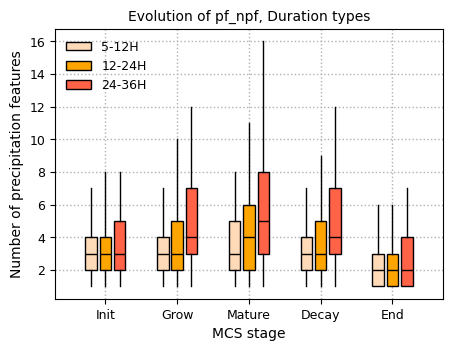

In [8]:
fig, ax = boxplot_groupby_duration_new(ds_var=ds_phase_multiyear_mcs.pf_npf, ds_duration_type=ds_phase_multiyear_mcs.duration_type)
ax.set_ylabel(r'Number of precipitation features', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of pf_npf, Duration types', fontsize=10)
plt.show()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/duration_types/boxplot_pf_npf_MCSstages.pdf',
            bbox_inches='tight', transparent=False)

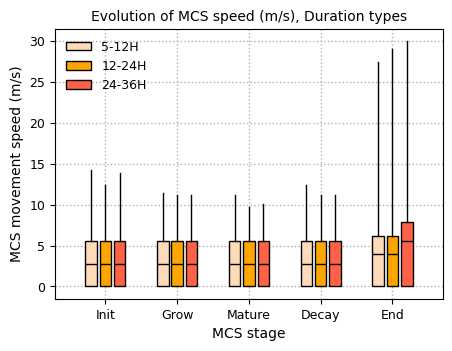

In [9]:
fig, ax = boxplot_groupby_duration_new(ds_var=ds_phase_multiyear_mcs.movement_speed, ds_duration_type=ds_phase_multiyear_mcs.duration_type)
ax.set_ylabel(r'MCS movement speed (m/s)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of MCS speed (m/s), Duration types', fontsize=10)
plt.show()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/duration_types/boxplot_movementspeed_MCSstages.pdf',
            bbox_inches='tight', transparent=False)

In [10]:
def vertprof_groupby_duration(ds_var, ds_duration_type, figsize_config):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=figsize_config)

    for ax,duration_type,color_type in zip([ax1,ax2,ax3],['SL','ML','LL'],['k','g','b']):
        idx =  np.where(ds_duration_type == duration_type)[0] # select duration type
        ds_var_sub = ds_var.isel(tracks=idx)

        for i,marker,label in zip(range(5), [None,'^','o','v','X'], ['Init','Grow','Mature','Decay','End']):
            varprof_mean = ds_var_sub.isel(mcs_phase=i).mean('tracks')
            varprof_stde = ds_var_sub.isel(mcs_phase=i).std('tracks')/np.sqrt(len(ds_var_sub.tracks))

            #for (data,pos) in zip(ds_duration, [i-0.2,i,i+0.2]):
            ax.plot(varprof_mean, ds_var_sub.level, marker=marker, color=color_type, label=label) # MCS stages
            ax.fill_betweenx(ds_var_sub.level, varprof_mean, varprof_mean-varprof_stde
                             , facecolor=color_type, alpha=0.5)
            ax.fill_betweenx(ds_var_sub.level, varprof_mean, varprof_mean+varprof_stde
                             , facecolor=color_type, alpha=0.5)         

            ax.tick_params(labelsize=9)
            ax.set_ylim([1000,100])
            ax.set_ylabel('Pressure [hPa]',fontsize=10)
            ax.grid(linestyle=':', linewidth=1)
            #ax.set_title('Evolution of MCS area (CCS,241K), Duration types', fontsize=10)

    return (fig, ax1, ax2, ax3)

In [11]:
# check "generate_envERA5_non2mcs_tracks_multiyear.sh" under /scratch/wmtsai/temp_mcs/scripts/mcs_envs
env_phase_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_stats_phase/')

year_list = np.arange(2001,2021)

num_strt = 0
ds_env_track_multiyear = []
for year in year_list:
    ds = xr.open_dataset(env_phase_dir / 'envERA5_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    track_renum = np.arange(num_strt, num_strt+len(ds.tracks))
    ds['tracks'] = track_renum

    ds_env_track_multiyear.append(ds)
    # update track number
    num_strt = num_strt + len(ds.tracks)    

ds_env_track_multiyear = xr.concat(ds_env_track_multiyear, dim='tracks')
ds_env_track_multiyear = ds_env_track_multiyear.isel(mcs_phase = [1,2,3,4,5])

In [12]:
ds_env_track_multiyear

<xarray.Dataset> Size: 477MB
Dimensions:              (tracks: 99154, mcs_phase: 5, level: 27)
Coordinates:
  * tracks               (tracks) int64 793kB 0 1 2 3 ... 99151 99152 99153
  * mcs_phase            (mcs_phase) <U6 120B 'Init' 'Grow' ... 'Decay' 'End'
  * level                (level) float64 216B 100.0 125.0 150.0 ... 975.0 1e+03
Data variables: (12/58)
    Q                    (tracks, mcs_phase, level) float32 54MB 1.37e-06 ......
    R                    (tracks, mcs_phase, level) float32 54MB 58.2 ... 78.11
    T                    (tracks, mcs_phase, level) float32 54MB 191.1 ... 302.4
    U                    (tracks, mcs_phase, level) float32 54MB -3.259 ... -...
    V                    (tracks, mcs_phase, level) float32 54MB -2.15 ... 0....
    W                    (tracks, mcs_phase, level) float32 54MB -0.005816 .....
    ...                   ...
    shear_dir_0to4km     (tracks, mcs_phase) float32 2MB 150.2 210.9 ... 54.79
    shear_dir_0to6km     (tracks, mcs_phase) float32 2MB 118.7 155.4 ... 72.22
    shear_dir_0to10km    (tracks, mcs_phase) float32 2MB 127.4 144.6 ... 122.9
    shear_dir_4to8km     (tracks, mcs_phase) float32 2MB 84.14 90.86 ... 168.3
    shear_dir_6to10km    (tracks, mcs_phase) float32 2MB 132.7 143.8 ... 151.8
    shear_dir_lcl_el     (tracks, mcs_phase) float32 2MB 121.6 134.1 ... 142.5
Attributes:
    Title:                     ERA5 domain mean environment data for MCS
    lon_box_size:              25
    lat_box_size:              25
    Institution:               Pacific Northwest National Laboratory
    Contact:                   Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                Fri Mar 10 14:47:19 2023
    spatial_avg_width_degree:  3.0

In [13]:
#### separating oceanic MCSs and land MCSs by landsea_flag
idx_oce = np.where(ds_phase_multiyear_mcs.landsea_flag.sel(mcs_phase = 'Init') == 0)[0]
idx_land = np.where(ds_phase_multiyear_mcs.landsea_flag.sel(mcs_phase = 'Init') == 1)[0]
ds_env_oce = ds_env_track_multiyear.isel(tracks=idx_oce)
ds_env_land = ds_env_track_multiyear.isel(tracks=idx_land)
ds_pstats_oce = ds_phase_multiyear_mcs.isel(tracks=idx_oce)
ds_pstats_land = ds_phase_multiyear_mcs.isel(tracks=idx_land)

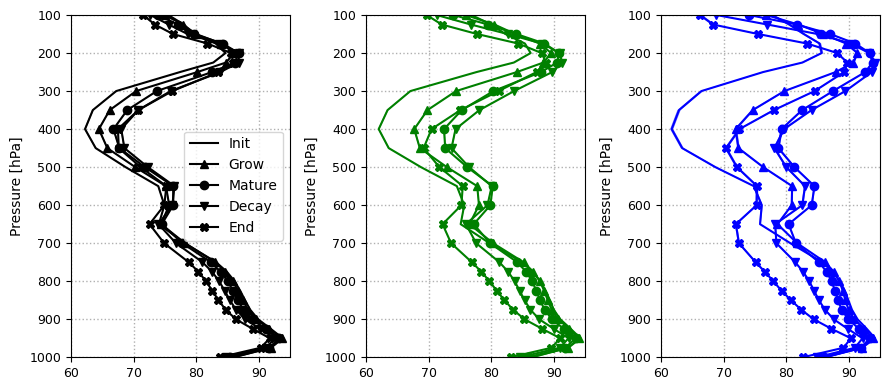

In [14]:
# oceanic MCSs

fig, ax1,ax2,ax3 = vertprof_groupby_duration(ds_env_oce.R, ds_pstats_oce.duration_type,
                                             figsize_config=(9,4))
# ax.set_ylabel(r'MCS movement speed (m/s)', fontsize=10)
# ax.set_xticks([0,1,2,3,4])
# ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
# ax.set_xlabel('MCS stage', fontsize=10)
# ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
# ax.tick_params(labelsize=9)
# #ax.set_ylim([200,400])
# ax.grid(linestyle=':', linewidth=1)
# ax.set_title('Evolution of MCS speed (m/s), Duration types', fontsize=10)
ax1.set_xlim([60,95])
ax2.set_xlim([60,95])
ax3.set_xlim([60,95])
ax1.legend()

plt.tight_layout()
plt.show()

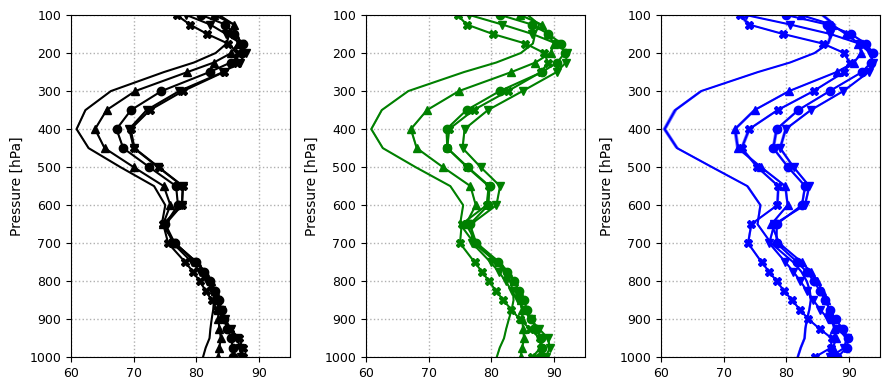

In [15]:
# land MCSs

fig, ax1,ax2,ax3 = vertprof_groupby_duration(ds_env_land.R, ds_pstats_land.duration_type,
                                             figsize_config=(9,4))
# ax.set_ylabel(r'MCS movement speed (m/s)', fontsize=10)
# ax.set_xticks([0,1,2,3,4])
# ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
# ax.set_xlabel('MCS stage', fontsize=10)
# ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
# ax.tick_params(labelsize=9)
# #ax.set_ylim([200,400])
# ax.grid(linestyle=':', linewidth=1)
# ax.set_title('Evolution of MCS speed (m/s), Duration types', fontsize=10)
ax1.set_xlim([60,95])
ax2.set_xlim([60,95])
ax3.set_xlim([60,95])
#ax1.legend(['Init','Grow','Mature','Decay','End'])

plt.tight_layout()
plt.show()

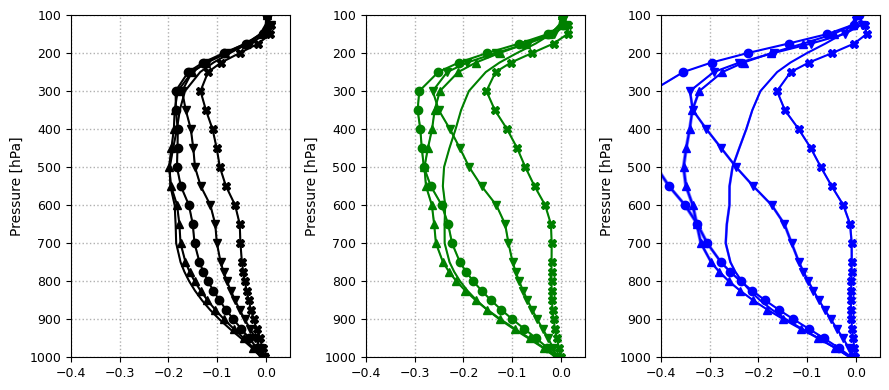

In [18]:
fig, ax1,ax2,ax3 = vertprof_groupby_duration(ds_var=ds_env_oce.W, ds_duration_type=ds_pstats_oce.duration_type,
                                             figsize_config=(9,4))
# ax.set_ylabel(r'MCS movement speed (m/s)', fontsize=10)
# ax.set_xticks([0,1,2,3,4])
# ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
# ax.set_xlabel('MCS stage', fontsize=10)
# ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
# ax.tick_params(labelsize=9)
# #ax.set_ylim([200,400])
# ax.grid(linestyle=':', linewidth=1)
# ax.set_title('Evolution of MCS speed (m/s), Duration types', fontsize=10)
ax1.set_xlim([-0.4,0.05])
ax2.set_xlim([-0.4,0.05])
ax3.set_xlim([-0.4,0.05])

plt.tight_layout()
plt.show()

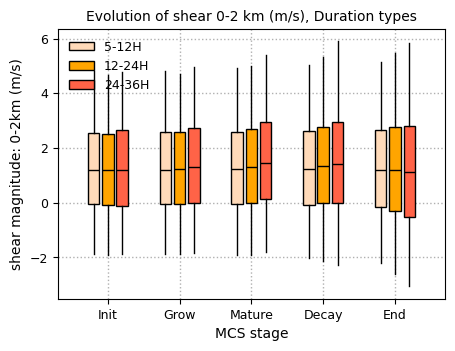

In [20]:
# shear difference: low-level wind shear
fig, ax = boxplot_groupby_duration_new(ds_env_oce.shear_mag_0to2km.isel(), ds_pstats_oce.duration_type)
ax.set_ylabel(r'shear magnitude: 0-2km (m/s)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of shear 0-2 km (m/s), Duration types', fontsize=10)
plt.show()

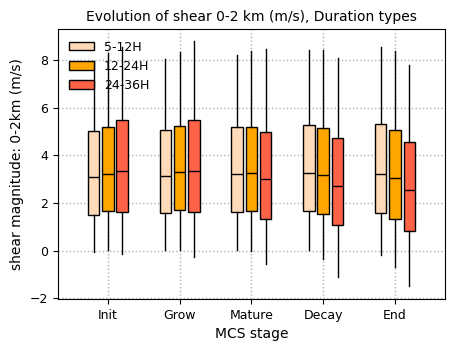

In [23]:
# shear difference: low-level wind shear over land
fig, ax = boxplot_groupby_duration_new(ds_env_land.shear_mag_0to2km.isel(), ds_pstats_land.duration_type)
ax.set_ylabel(r'shear magnitude: 0-2km (m/s)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of shear 0-2 km (m/s), Duration types', fontsize=10)
plt.show()

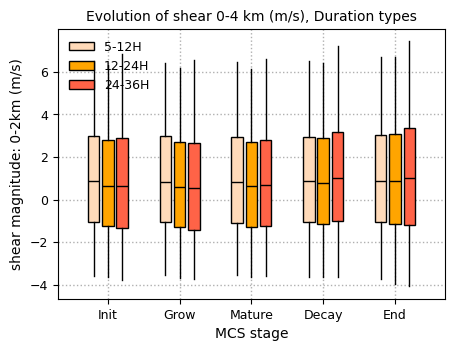

In [ ]:
# shear difference: low-level wind shear
fig, ax = boxplot_groupby_duration_new(ds_env_oce.shear_mag_0to4km.isel(), ds_pstats_oce.duration_type)
ax.set_ylabel(r'shear magnitude: 0-2km (m/s)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of shear 0-4 km (m/s), Duration types', fontsize=10)
plt.show()

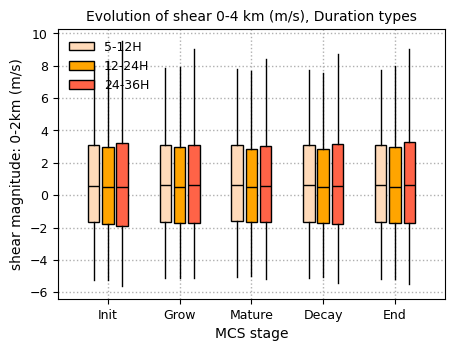

In [22]:
# shear difference: low-level wind shear
fig, ax = boxplot_groupby_duration_new(ds_env_oce.shear_mag_4to8km.isel(), ds_pstats_oce.duration_type)
ax.set_ylabel(r'shear magnitude: 0-2km (m/s)', fontsize=10)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(ds_phase_multiyear_mcs.mcs_phase.values)
ax.set_xlabel('MCS stage', fontsize=10)
ax.legend(['5-12H','12-24H','24-36H'], fontsize=9, frameon=False, loc=2)
ax.tick_params(labelsize=9)
#ax.set_ylim([200,400])
ax.grid(linestyle=':', linewidth=1)
ax.set_title('Evolution of shear 0-4 km (m/s), Duration types', fontsize=10)
plt.show()

In [12]:
ds = xr.open_dataset('/scratch/wmtsai/ERA-5/NC_FILES/2014/era-5.omega.2014.02.nc')
ds = ds.reindex(latitude=sorted(list(ds.latitude)), level=sorted(ds.level, reverse=True))
ds_sub = ds.isel(time=0).sel(latitude=slice(-10,-5),longitude=slice(50,60))
ds_sub.w

<xarray.DataArray 'w' (level: 27, latitude: 21, longitude: 41)> Size: 186kB
[23247 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 164B 50.0 50.25 50.5 ... 59.5 59.75 60.0
  * latitude   (latitude) float32 84B -10.0 -9.75 -9.5 -9.25 ... -5.5 -5.25 -5.0
  * level      (level) int32 108B 1000 975 950 925 900 ... 200 175 150 125 100
    time       datetime64[ns] 8B 2014-02-01
Attributes:
    units:          Pa s**-1
    long_name:      Vertical velocity
    standard_name:  lagrangian_tendency_of_air_pressure

In [14]:
tmp = np.reshape(ds_sub.w.values, (len(ds_sub.level), len(ds_sub.longitude)*len(ds_sub.latitude)))

In [16]:
tmp.shape

(27, 861)